In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/DACON/중고차 가격 예측/data.zip' -d '/content'

<center><img src=""></center>

<center><h1>중고차 가격 예측 경진대회</h1></center>
<center><h3>데이콘 베이직 Basic | 정형 | NMAE</h3></center>

### 📚 Import Libraries

In [3]:
import os
import gc
import time
import random
import math
import platform
import sklearn
import sys

from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')
matplotlib.rc('figure', figsize=(20,8))

mpl.rcParams['axes.unicode_minus'] = False
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"

# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
def custom_palette(custom_colors):
    cp = sns.color_palette(custom_colors)
    sns.set_palette(cp)
    sns.palplot(cp, size=0.8)
    plt.tick_params(axis='both', labelsize=0, length=0)

Notebook Color Scheme:


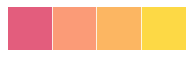

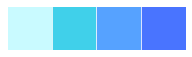

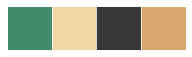

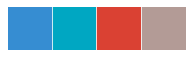

In [4]:
print(clr.S+"Notebook Color Scheme:"+clr.E)

pink = ["#E35D7D", "#FB9B77", "#FCB662", "#FDD945"]
blue = ["#C9FAFF", "#40D0EA", "#56A2FF", "#4974FF"]
my_color1 = ["#448B69", "#F1D7A5", "#373737", "#D8A76C"]
my_color2 = ["#368DD2", "#00A7C2", "#DA4133", "#B39B96"]
custom_palette(pink)
custom_palette(blue)
custom_palette(my_color1)
custom_palette(my_color2)

In [5]:
# 환경 및 버전 확인
print(clr.S + "- os: "+clr.E + f"{platform.platform()}")
print(clr.S + "- python: " + clr.E + f"{sys.version}")
print(clr.S + "- pandas: " + clr.E + f"{pd.__version__}")
print(clr.S + "- numpy: " + clr.E + f"{np.__version__}")
print(clr.S + "- sklearn: " + clr.E + f"{sklearn.__version__}")
# cpu_use = '\033[1m\033[31mCPU\033[0m'
# print(clr.S + "- opencv: " + clr.E + f"{cv2.__version__}")
# print(clr.S + "Setup complete. Using torch " + clr.E + f"{torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else cpu_use})")

- os: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 0.23.2


<h2> 📂 Load Data </h2>
<h3> Dataset </h3>
train : 1,015 rows, 11 columns <br>
test : 439 rows 10 columns

***
Columns
```
id : 샘플 아이디
title : 제조사 모델명
odometer : 주행 거리
location : 판매처(나이지리아 도시)
isimported : 현지 사용 여부
engine : 엔진 종류
transmission : 트랜스미션 종류
fuel : 연료 종류
paint : 페인트 색상
year : 제조년도
target : 자동차 가격
```

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
display(train_df.head())
display(test_df.head())

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


In [7]:
print(clr.S + "train_df.info()"+clr.E)
display(train_df.info())
print(clr.S + "test_df.info()"+clr.E)
display(test_df.info())

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


None

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            436 non-null    int64 
 1   title         436 non-null    object
 2   odometer      436 non-null    int64 
 3   location      436 non-null    object
 4   isimported    436 non-null    object
 5   engine        436 non-null    object
 6   transmission  436 non-null    object
 7   fuel          436 non-null    object
 8   paint         436 non-null    object
 9   year          436 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.2+ KB


None

결측값 존재하지 않음. 자료형도 적절한 것으로 보임.

## 범주형 자료 살펴보기

In [8]:
cat_cols = train_df.select_dtypes('object')
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    display(train_df[col].value_counts())

============title=============


Toyota Camry             129
Toyota Corolla           108
Toyota Highlander         50
Toyota Sienna             49
Toyota RAV 4              40
                        ... 
Scania P94 FLATBED         1
Mercedes-Benz GLA 250      1
Acura ZDX                  1
Iveco TRUCK                1
DAF CF                     1
Name: title, Length: 203, dtype: int64

===========location===========


Lagos          792
Abuja          146
Ogun            26
Lagos           23
Lagos State     16
other            4
FCT              2
Accra            1
Abuja            1
Abia State       1
Adamawa          1
Abia             1
Ogun State       1
Name: location, dtype: int64

==========isimported==========


Foreign Used    744
Locally used    248
New              23
Name: isimported, dtype: int64

============engine============


4-cylinder(I4)    618
6-cylinder(V6)    222
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

=========transmission=========


automatic    965
manual        50
Name: transmission, dtype: int64

=============fuel=============


petrol    970
diesel     45
Name: fuel, dtype: int64

============paint=============


Black          292
White          115
Silver         103
Grey            84
Blue            70
              ... 
WINE             1
Silver/grey      1
Ink blue         1
Light blue       1
Off white l      1
Name: paint, Length: 76, dtype: int64

In [9]:
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    display(test_df[col].value_counts())

============title=============


Toyota Corolla           52
Toyota Camry             52
Toyota Highlander        30
Toyota Sienna            29
Toyota RAV 4             19
                         ..
Mercedes-Benz Maybach     1
Acura TSX                 1
Mercedes-Benz GLA 180     1
Volvo S80                 1
Lexus GX 470              1
Name: title, Length: 124, dtype: int64

===========location===========


Lagos                338
Abuja                 68
Lagos                 11
Ogun                   8
Lagos State            5
Mushin                 1
other                  1
Abuja                  1
Arepo ogun state       1
Ogun State             1
Abia                   1
Name: location, dtype: int64

==========isimported==========


Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

============engine============


4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

=========transmission=========


automatic    414
manual        22
Name: transmission, dtype: int64

=============fuel=============


petrol    416
diesel     20
Name: fuel, dtype: int64

============paint=============


Black                      118
Silver                      62
White                       45
Red                         36
Grey                        30
Blue                        27
white                       16
Dark Grey                   14
Gray                        13
Gold                         9
Green                        8
Brown                        5
Black                        4
Dark Blue                    4
Dark Green                   3
Yellow                       3
Blue                         3
green                        3
Ash                          2
Wine                         2
Grey                         2
Sliver                       2
Light Grey                   2
White and green              1
Dark blue                    1
Beige                        1
Classic Silver Met(1F7)      1
Green                        1
Grey and black               1
  Brown                      1
Indigo ink pearl             1
Navy blue                    1
blue    

In [10]:
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    print(clr.S + f"train_df만 있는 값"+clr.E)
    print((set(train_df[col].unique()) | set(test_df[col].unique())) - set(test_df[col].unique()))
    print(clr.S + f"test_df만 있는 값"+clr.E)
    print((set(train_df[col].unique()) | set(test_df[col].unique())) - set(train_df[col].unique()))

============title=============
train_df만 있는 값
{'Land Rover Range Rover Velar', 'BMW 745', 'Land Rover Range Rover Evoque', 'Mercedes-Benz GL 450', 'Mack CH613', 'Nissan Titan', 'Mercedes-Benz 320', 'BMW 325', 'Mercedes-Benz 200', 'Porsche Panamera', 'Toyota Dyna', 'Toyota Vitz', 'BMW 335', 'Scania TRACTOR HEAD', 'Volkswagen 17.22', 'BMW 740', 'Porsche Macan', 'Bentley Arnage', 'Lexus ES 330', 'Volkswagen T6 other', 'Mercedes-Benz E 550', 'IVM LT35', 'Mercedes-Benz CLA 250', 'Kia Cerato', 'Kia Stinger', 'Infiniti JX', 'Mercedes-Benz G 63 AMG', 'Mercedes-Benz 350', 'Hyundai ix35', 'Jeep Cherokee', 'Infiniti QX80', 'Honda Insight', 'Nissan Frontier', 'Mercedes-Benz/52', 'Mack CXN613', 'Mercedes-Benz 709 DB', 'Jaguar X-Type', 'Mazda CX-9', 'Hyundai Tucson', 'DAF CF', 'Volvo XC90', 'Dodge Charger', 'Man Diesel 19.314 FILT-N', 'Volkswagen Tiguan', 'Kia Picanto', 'Nissan Versa', 'Audi S6', 'BMW X6', 'Jaguar XJ8', 'BMW 730', 'Mazda Tribute', 'Peugeot 607', 'Nissan X-Trail', 'Mack CH613 CONVENT

### 제조사, 모델에 따른 가격 차이
- 제조사와 모델명 분리
- Land Rover와 Mercedes-Benz/52 다른 title과는 다르게 작성되어 있어서 따로 처리
- Mercedes-Benz/52는 모델명이 52인지? 해당 모델 검색해봐도 나오지 않음. 이상치로 판단


In [11]:
train_df['title'] = train_df['title'].str.lower()
train_df['manufacturer'] = train_df['title'].str.split(' ', expand=True)[0]    # Manufacturer
train_df.loc[train_df.manufacturer == 'man-volkswagen', 'manufacturer'] = 'man'
train_df.loc[train_df.manufacturer == 'land', 'manufacturer'] = 'land rover'
train_df.loc[train_df.manufacturer == 'mercedes-benz/52', 'manufacturer'] = 'mercedes-benz'

In [12]:
train_df['model_name'] = train_df['title'].apply(lambda x: ' '.join(x.split()[1:]))
train_df.loc[train_df['manufacturer'] == 'land rover', 'model_name'] = train_df.loc[train_df['manufacturer'] == 'land rover', 'title'].str.replace('land rover ', '')

In [13]:
display(train_df['manufacturer'].unique())
train_df['manufacturer'].nunique()

array(['toyota', 'land rover', 'lexus', 'pontiac', 'ford', 'honda',
       'volvo', 'bmw', 'infiniti', 'mercedes-benz', 'hyundai', 'jaguar',
       'mitsubishi', 'nissan', 'mack', 'chevrolet', 'mazda', 'lincoln',
       'kia', 'volkswagen', 'acura', 'daf', 'man', 'isuzu', 'ivm',
       'porsche', 'mini', 'dodge', 'gmc', 'iveco', 'scania', 'gac',
       'peugeot', 'rolls-royce', 'jeep', 'alpina', 'bentley', 'jmc',
       'audi'], dtype=object)

39

In [14]:
test_df['title'] = test_df['title'].str.lower()
test_df['manufacturer'] = test_df['title'].str.split(' ', expand=True)[0]
test_df.loc[test_df.manufacturer == 'man-volkswagen', 'manufacturer'] = 'man'
test_df.loc[test_df.manufacturer == 'land', 'manufacturer'] = 'land rover'
test_df['model_name'] = test_df['title'].apply(lambda x: ' '.join(x.split()[1:]))
test_df.loc[test_df['manufacturer'] == 'land rover', 'model_name'] = test_df.loc[test_df['manufacturer'] == 'land rover', 'title'].str.replace('land rover ', '')
display(test_df['manufacturer'].unique())
test_df['manufacturer'].nunique()

array(['mercedes-benz', 'honda', 'toyota', 'iveco', 'lexus', 'nissan',
       'volkswagen', 'jeep', 'ford', 'bmw', 'mack', 'land rover',
       'hyundai', 'peugeot', 'volvo', 'infiniti', 'acura', 'man', 'fiat',
       'mini', 'daf', 'mazda', 'porsche', 'mitsubishi', 'chevrolet',
       'kia', 'pontiac', 'rolls-royce'], dtype=object)

28

In [15]:
print(clr.S + f"train_df만 있는 값"+clr.E)
print((set(train_df['manufacturer'].unique()) | set(test_df['manufacturer'].unique())) - set(test_df['manufacturer'].unique()))
print(clr.S + f"test_df만 있는 값"+clr.E)
print((set(train_df['manufacturer'].unique()) | set(test_df['manufacturer'].unique())) - set(train_df['manufacturer'].unique()))

train_df만 있는 값
{'gmc', 'scania', 'jmc', 'jaguar', 'ivm', 'alpina', 'dodge', 'bentley', 'isuzu', 'gac', 'audi', 'lincoln'}
test_df만 있는 값
{'fiat'}


In [16]:
test_df[test_df['manufacturer'] == 'fiat']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
158,158,fiat ducato,12488,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Green,2001,fiat,ducato


In [17]:
display(train_df.manufacturer.value_counts().head())
display(train_df.manufacturer.value_counts().tail())

toyota           474
lexus            122
mercedes-benz    106
honda             81
ford              36
Name: manufacturer, dtype: int64

rolls-royce    1
gmc            1
dodge          1
lincoln        1
audi           1
Name: manufacturer, dtype: int64

## 제조사 별 평균 자동차 가격
😱 Rolls-Royce... 그저 빛

In [18]:
matplotlib.rc('figure', figsize=(20,8))

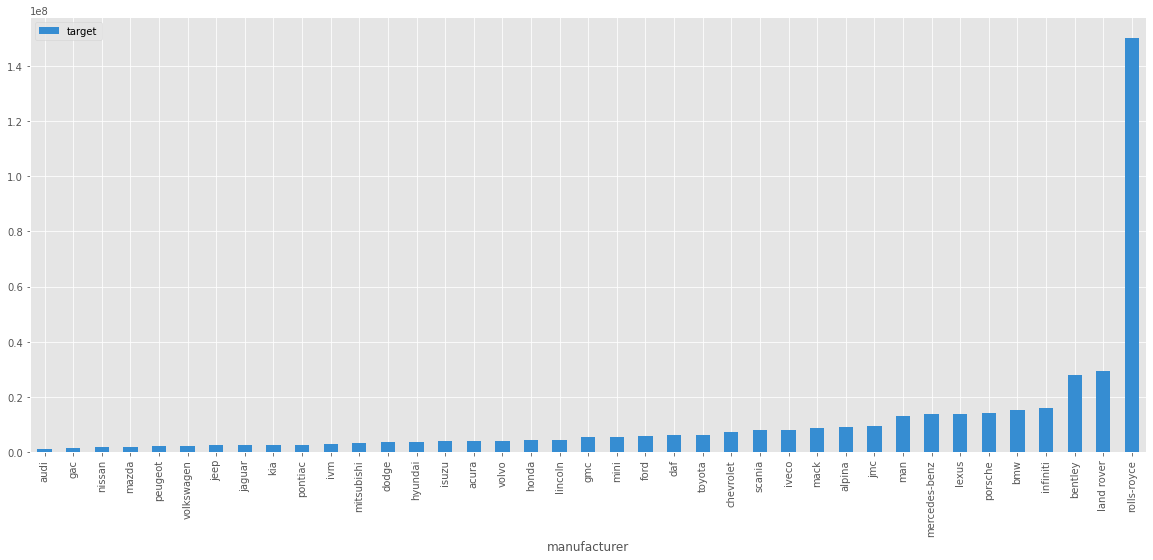

In [19]:
train_df.groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

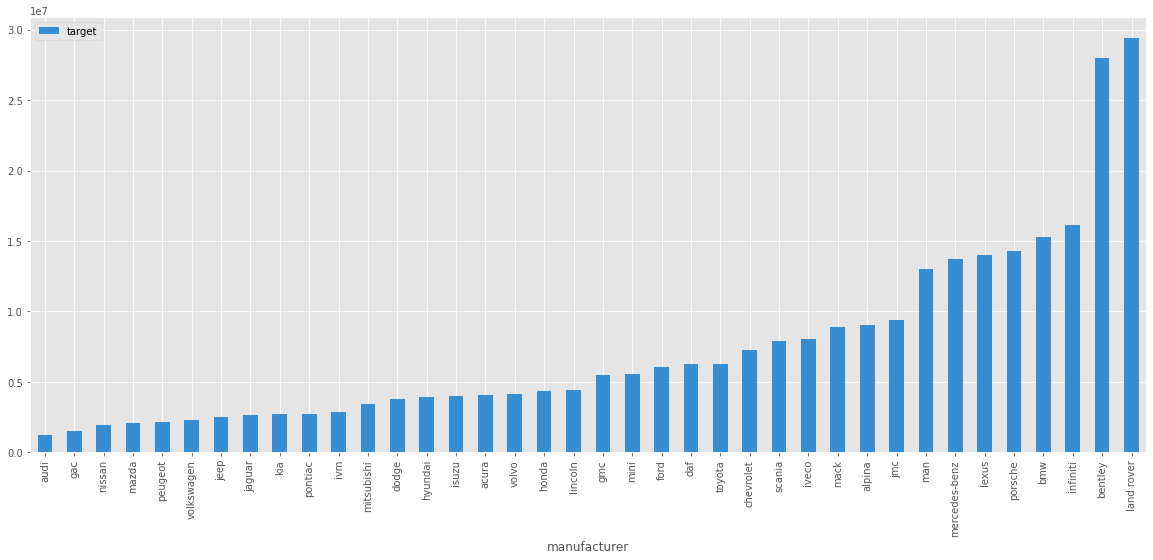

In [20]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

## 동일 제조사 모델 별 평균 가격

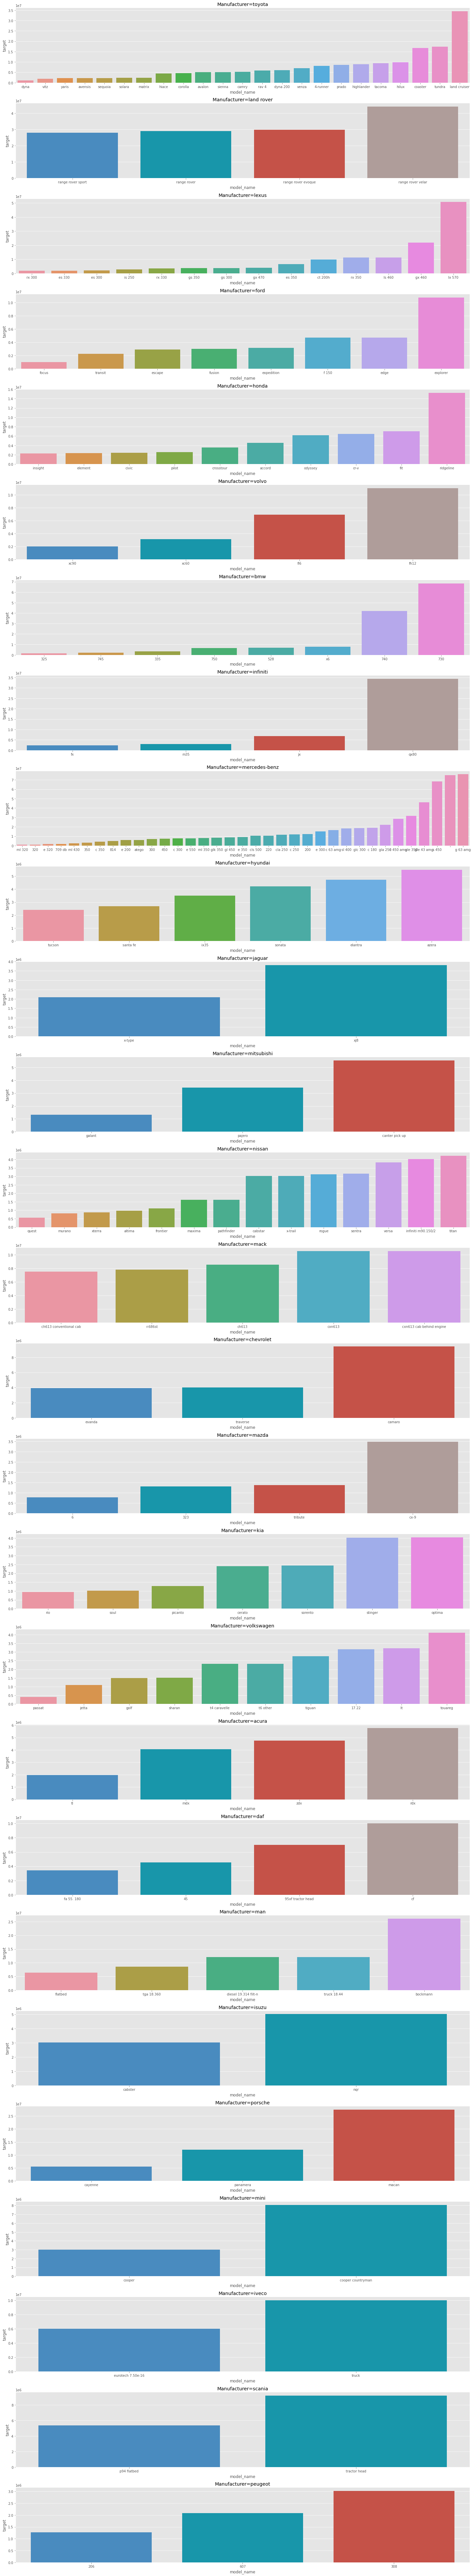

27


In [21]:
n = len(train_df['manufacturer'].unique())
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 4 * n))
count = 0
for manufacturer in train_df['manufacturer'].unique():
    if len(train_df[train_df['manufacturer'] == manufacturer].model_name.unique()) < 2:
        continue
    _data = train_df[train_df['manufacturer'] == manufacturer].groupby('model_name')['target'].mean().reset_index().sort_values(by='target')
    sns.barplot(data=_data, x='model_name', y='target', ax=ax.flat[count])
    ax.flat[count].set(title='Manufacturer=' + manufacturer)
    count += 1
fig.tight_layout()
for i in range(count, n):
    fig.delaxes(ax.flat[i])
plt.show();
print(count)

### 제조 년도에 따른 평균 가격


왜도 21.650619032991404
첨도 478.3507029697167


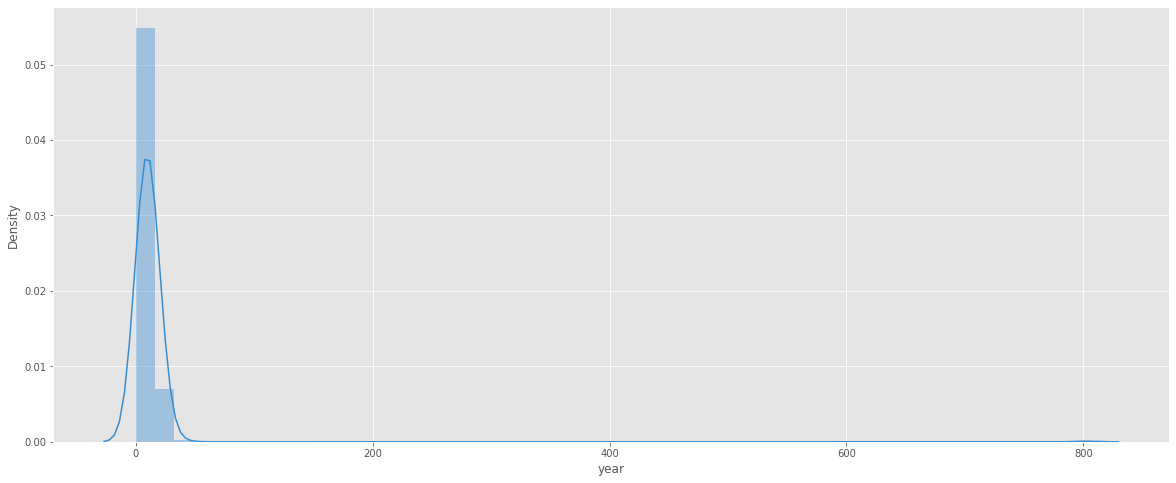

In [22]:
from scipy.stats import skew, kurtosis
print(clr.S + "왜도"+clr.E, skew(2020 - train_df['year']))
print(clr.S + "첨도"+clr.E, kurtosis(2020 - train_df['year']))
sns.distplot(2020 - train_df['year'], kde=True);

In [23]:
train_df['year'].value_counts()

2008    82
2013    73
2010    71
2016    70
2014    68
2007    68
2011    59
2009    57
2012    56
2006    56
2018    47
2015    45
2005    44
2004    36
2003    34
2017    29
2001    21
2019    17
2002    17
2020    17
2000    12
1999    10
1996     7
1998     5
1995     3
1994     3
1991     2
1985     1
1218     1
1982     1
1997     1
1217     1
1980     1
Name: year, dtype: int64

1218, 1217년에 제조된 유물 자동차가 있다..? <br>
각각 2008, 2007을 잘못 입력한 것으로 예상. 확인해봅시다<br>
1. 동일한 엔진을 가진 자동차들의 평균 year를 넣어주고
2. 동일한 엔진 가진 자동차들의 연 평균 주행거리 * year로 odometer 결측치 채우기

그나저나 Mercedes-Benz/52는 무슨 모델인지 나오지 않는다.<br>

In [24]:
display(train_df[train_df['year'] == 1217])
display(train_df[train_df['year'] == 1218])

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name
827,827,mercedes-benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000,mercedes-benz,


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name
415,415,mercedes-benz atego,403461,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,1218,6015000,mercedes-benz,atego


In [25]:
train_df['odometer_per_year'] = train_df['odometer'] / (2021 - train_df['year'])

In [26]:
print(train_df[train_df['year'] == 1217].engine)
print(train_df[train_df['year'] == 1218].engine)

827    6-cylinder(V6)
Name: engine, dtype: object
415    4-cylinder(I4)
Name: engine, dtype: object


In [27]:
train_df.loc[train_df['year'] == 1217, 'year'] = np.nan
train_df.loc[train_df['year'] == 1218, 'year'] = np.nan
train_df.loc[train_df['odometer'] == 0, 'odometer'] = np.nan

In [28]:
year_groupby_engine = train_df.dropna().groupby('engine')['year'].mean()
year_groupby_engine

engine
2-cylinder(I2)    2009.000000
3-cylinder(I3)    2010.000000
4-cylinder(H4)    2013.500000
4-cylinder(I4)    2010.275862
5-cylinder(I5)    2010.000000
6-cylinder(I6)    2010.141593
6-cylinder(V6)    2009.168224
8-cylinder(V8)    2011.500000
Name: year, dtype: float64

In [29]:
for _id in train_df[train_df['year'].isna()].id.tolist():
    train_df.loc[train_df['id'] == _id, 'year'] = int(year_groupby_engine[train_df.loc[train_df['id'] == _id, 'engine']])

In [30]:
print(train_df.loc[train_df['id'] == 415, 'year'])
print(train_df.loc[train_df['id'] == 827, 'year'])

415    2010.0
Name: year, dtype: float64
827    2009.0
Name: year, dtype: float64


In [31]:
odometer_per_year_group = train_df.dropna().groupby('engine')['odometer_per_year'].mean()
odometer_per_year_group

engine
2-cylinder(I2)    10904.416667
3-cylinder(I3)    14570.901961
4-cylinder(H4)     7264.750000
4-cylinder(I4)    10728.361985
5-cylinder(I5)    14755.966667
6-cylinder(I6)    10370.627557
6-cylinder(V6)    11328.244277
8-cylinder(V8)     8877.655011
Name: odometer_per_year, dtype: float64

In [32]:
int((2021 - train_df.loc[train_df['id'] == 52, 'year'].values[0]) * odometer_per_year_group[train_df.loc[train_df['id'] == 52, 'engine']].values[0])

160925

In [33]:
for _id in train_df[train_df['odometer'].isna()].id.tolist():
    train_df.loc[train_df['id'] == _id, 'odometer'] = int((2021 - train_df.loc[train_df['id'] == _id, 'year'].values[0]) * odometer_per_year_group[train_df.loc[train_df['id'] == _id, 'engine']].values[0])

In [34]:
train_df.isna().sum()

id                   0
title                0
odometer             0
location             0
isimported           0
engine               0
transmission         0
fuel                 0
paint                0
year                 0
target               0
manufacturer         0
model_name           0
odometer_per_year    0
dtype: int64

테스트 데이터에도 이상치 존재: id 304, 406, 411<br>

In [35]:
test_df[(test_df['year'] > 2020) | (test_df['year'] < 1900)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
304,304,mercedes-benz cabin plus chassis only,650923,Lagos,Locally used,6-cylinder(V6),manual,diesel,blue,1324,mercedes-benz,cabin plus chassis only
406,406,mercedes-benz dump truck,0,Lagos,Locally used,8-cylinder(V8),manual,diesel,white,2626,mercedes-benz,dump truck
411,411,mercedes-benz water tanker,701934,Lagos,Locally used,8-cylinder(V8),manual,diesel,white,1726,mercedes-benz,water tanker


In [36]:
test_df.loc[(test_df['year'] > 2020) | (test_df['year'] < 1900), 'year']

304    1324
406    2626
411    1726
Name: year, dtype: int64

In [37]:
test_df.loc[test_df['odometer'] == 0, 'odometer'] = np.nan
test_df.loc[(test_df['year'] > 2020) | (test_df['year'] < 1900), 'year'] = np.nan

In [38]:
for _id in test_df[test_df['year'].isna()].id.tolist():
    test_df.loc[test_df['id'] == _id, 'year'] = int(year_groupby_engine[test_df.loc[test_df['id'] == _id, 'engine']])

In [39]:
for _id in test_df[test_df['year'].isna()].id.tolist():
    try:
        test_df.loc[test_df['id'] == _id, 'year'] = 2021 - int(test_df.loc[test_df['id'] == _id, 'odometer'].values[0] / odometer_per_year_group[test_df.loc[test_df['id'] == _id, 'engine']].values[0])
    except:
        pass

In [40]:
test_df[(test_df['id'] == 304) | (test_df['id'] == 411)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
304,304,mercedes-benz cabin plus chassis only,650923.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,blue,2009.0,mercedes-benz,cabin plus chassis only
411,411,mercedes-benz water tanker,701934.0,Lagos,Locally used,8-cylinder(V8),manual,diesel,white,2011.0,mercedes-benz,water tanker


In [41]:
for _id in test_df[test_df['odometer'].isna()].id.tolist():
    test_df.loc[test_df['id'] == _id, 'odometer'] = int((2021 - test_df.loc[test_df['id'] == _id, 'year'].values[0]) * odometer_per_year_group[test_df.loc[test_df['id'] == _id, 'engine']].values[0])

In [42]:
test_df.isna().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
manufacturer    0
model_name      0
dtype: int64

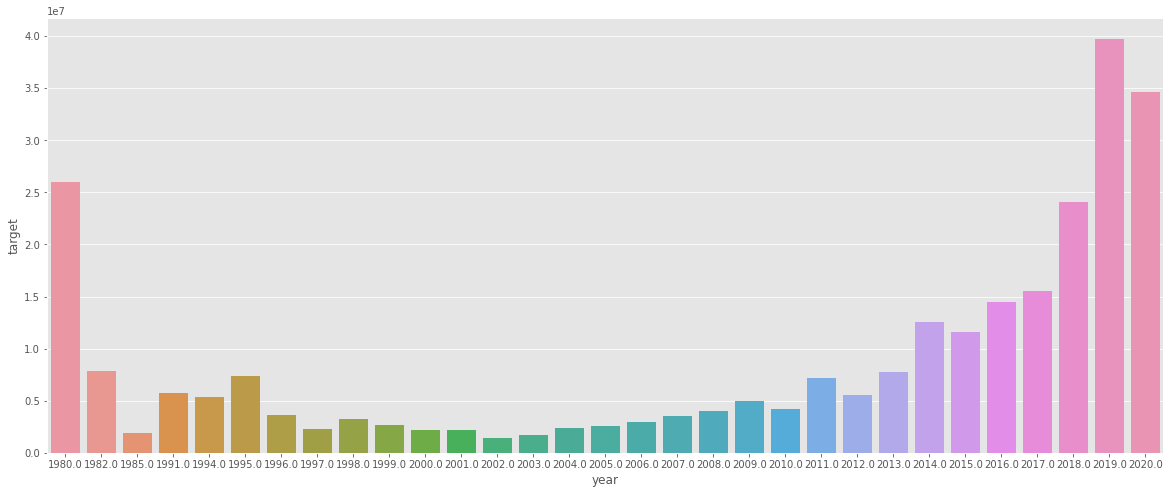

In [43]:
_data = train_df.groupby('year')['target'].mean().reset_index()
sns.barplot(data=_data, x='year', y='target');

In [44]:
train_df[train_df['year'] <= 1985.0]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year
100,100,volkswagen lt,161966.0,Lagos,Locally used,6-cylinder(V6),manual,petrol,orange,1985.0,1915000,volkswagen,lt,4499.055556
608,608,mack r-686st,441801.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,red,1982.0,7815000,mack,r-686st,0.000000
1009,1009,man bockmann,809456.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1980.0,26015000,man,bockmann,19742.829268


In [45]:
test_df[test_df['year'] <= 1985.0]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name


In [46]:
train_df[train_df['manufacturer'] == 'man']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year
121,121,man tga 18.360,192580.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,2004.0,8515000,man,tga 18.360,0.000000
429,429,man truck 18.44,147267.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,2008.0,12015000,man,truck 18.44,0.000000
610,610,man diesel 19.314 filt-n,798469.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,blue,2001.0,12015000,man,diesel 19.314 filt-n,39923.450000
679,679,man-volkswagen flatbed,147267.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,2008.0,6340000,man,flatbed,0.000000
1009,1009,man bockmann,809456.0,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1980.0,26015000,man,bockmann,19742.829268


608, 1009, 100 데이터는 제거하도록 함

In [47]:
train_df.drop([608, 1009, 100], inplace=True)

In [48]:
train_df[train_df['year'] == 2019]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year
1,1,toyota land cruiser,10.0,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019.0,33015000,toyota,land cruiser,5.0
169,169,honda accord,18506.0,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2019.0,13665000,honda,accord,9253.0
241,241,toyota sienna,12004.0,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Silver,2019.0,17815000,toyota,sienna,6002.0
294,294,mercedes-benz gla 250,21944.0,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2019.0,22015000,mercedes-benz,gla 250,10972.0
295,295,toyota land cruiser,46.0,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019.0,37015000,toyota,land cruiser,23.0
303,303,toyota camry,2878.0,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2019.0,23015000,toyota,camry,1439.0
332,332,mercedes-benz s 450,90.0,Lagos,Foreign Used,8-cylinder(V8),automatic,petrol,Black,2019.0,68265000,mercedes-benz,s 450,45.0
341,341,land rover range rover sport,18720.0,Lagos,Foreign Used,8-cylinder(V8),automatic,petrol,Grey,2019.0,117015000,land rover,range rover sport,9360.0
353,353,toyota corolla,21.0,Lagos State,New,6-cylinder(V6),automatic,petrol,Black,2019.0,33015000,toyota,corolla,10.5
364,364,toyota land cruiser,81.0,other,New,6-cylinder(V6),automatic,petrol,Black,2019.0,33040000,toyota,land cruiser,40.5


In [49]:
test_df['year'].unique().max()

2020.0

In [50]:
train_df['year'] = train_df['year'].astype(int)
test_df['year'] = test_df['year'].astype(int)

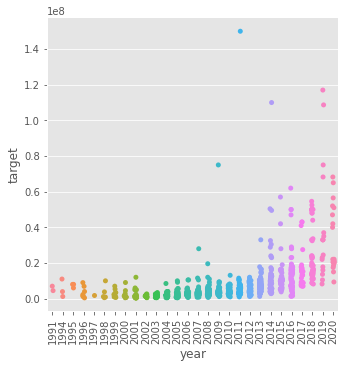

In [51]:
sns.catplot(data=train_df, x='year', y='target')
plt.xticks(rotation=90)
plt.show();

In [52]:
train_df[(train_df['year'] == 2011) & (train_df['target'] > 14000000)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year
597,597,rolls-royce ghost,16069.0,Lagos,Locally used,4-cylinder(I4),automatic,petrol,Black,2011,150015008,rolls-royce,ghost,1606.9


### Location에 따른 가격
같은 지역이 다르게 표기되어있는 데이터가 많아서 변경필요<br>
FCT는 아부자의 연방 수도<br>
Mushin 라고스에 속하는 것으로 보임

In [53]:
train_df['location'].value_counts()

Lagos          789
Abuja          146
Ogun            26
Lagos           23
Lagos State     16
other            4
FCT              2
Accra            1
Abuja            1
Abia State       1
Adamawa          1
Abia             1
Ogun State       1
Name: location, dtype: int64

In [54]:
test_df['location'].value_counts()

Lagos                338
Abuja                 68
Lagos                 11
Ogun                   8
Lagos State            5
Mushin                 1
other                  1
Abuja                  1
Arepo ogun state       1
Ogun State             1
Abia                   1
Name: location, dtype: int64

In [55]:
def clean_location(x):
    x = x.lower().strip()
    x = x.replace(' State', '')
    if x in ['mushin', 'lagos']:
        return 'lagos'
    elif x in ['fct', 'abuja']:
        return 'abuja'
    elif x in ['ogun','arepo ogun']:
        return 'ogun'
    else:
        return 'other'

In [56]:
train_df['location'] = train_df['location'].apply(lambda x: clean_location(x))
train_df['location'].value_counts()

lagos    812
abuja    149
ogun      26
other     25
Name: location, dtype: int64

In [57]:
test_df['location'] = test_df['location'].apply(lambda x: clean_location(x))
test_df['location'].value_counts()

lagos    350
abuja     69
other      9
ogun       8
Name: location, dtype: int64

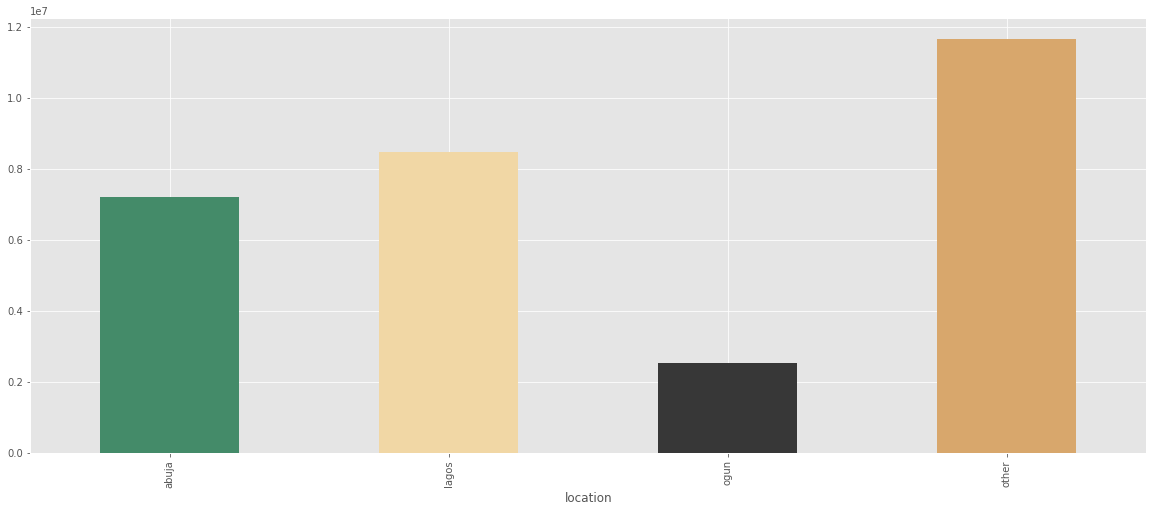

In [58]:
train_df.groupby('location')['target'].mean().plot(kind='bar', color=my_color1+my_color2);

Location 일원분산분석 

In [59]:
A = train_df.loc[train_df['location'] == 'abuja', 'target']
B = train_df.loc[train_df['location'] == 'lagos', 'target']
C = train_df.loc[train_df['location'] == 'ogun', 'target']
D = train_df.loc[train_df['location'] == 'other', 'target']

In [60]:
from scipy.stats import *
print(clr.S + "각 그룹의 분포가 정규분포를 따르는지 확인" +clr.E)

print(kstest(A, 'norm'))
print(kstest(B, 'norm'))
print(kstest(C, 'norm'))
print(kstest(D, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(A, B, C, D))

각 그룹의 분포가 정규분포를 따르는지 확인
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=2.932718955407993, pvalue=0.032594141986443115)


In [61]:
# 사후분석
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(clr.S + "p-value 0.05미만으로 차이가 존재하므로 사후분석 수행" +clr.E)
Group = ["A"] * len(A) + ["B"] * len(B) + ["C"] * len(C) + ["D"] * len(D)
Data = A.tolist() + B.tolist() + C.tolist() + D.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value 0.05미만으로 차이가 존재하므로 사후분석 수행


group1,group2,meandiff,p-adj,lower,upper,reject
A,B,1268204.0205,0.6393,-1567515.2516,4103923.2926,False
A,C,-4688606.8663,0.2817,-11451178.927,2073965.1944,False
A,D,4442846.9799,0.3446,-2433917.8922,11319611.8519,False
B,C,-5956810.8868,0.0744,-12295946.0288,382324.2552,False
B,D,3174642.9594,0.5756,-3286173.4424,9635459.3612,False
C,D,9131453.8462,0.0422,218921.9015,18043985.7908,True


Location은 other, ogun feature를 만들어 사용하기로 함

## 현지 사용 여부에 따른 가격차

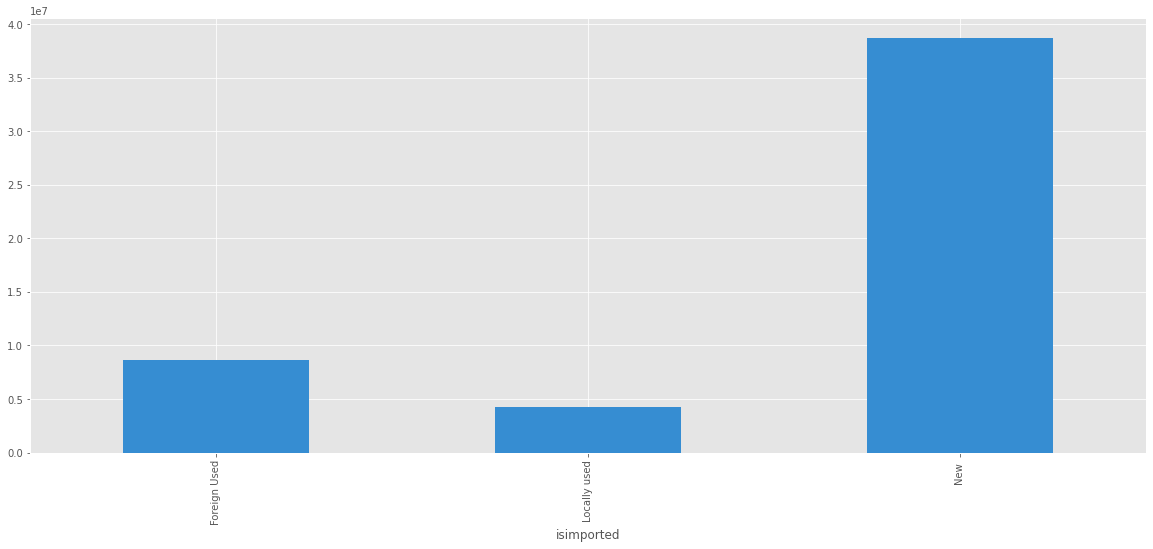

In [62]:
train_df.groupby('isimported')['target'].mean().plot(kind='bar');

In [63]:
train_df['isimported'] = train_df['isimported'].apply(lambda x: x.strip())
train_df[train_df['isimported'] == 'New']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year
1,1,toyota land cruiser,10.0,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,toyota,land cruiser,5.000000
164,164,toyota corolla,101.0,abuja,New,4-cylinder(I4),automatic,petrol,Dark Grey,2018,8215000,toyota,corolla,33.666667
216,216,mercedes-benz gle 350,693.0,lagos,New,4-cylinder(I4),automatic,petrol,Blue,2020,56515000,mercedes-benz,gle 350,693.000000
295,295,toyota land cruiser,46.0,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,37015000,toyota,land cruiser,23.000000
316,316,honda civic,24997.0,abuja,New,4-cylinder(I4),automatic,petrol,White,2018,8665000,honda,civic,8332.333333
353,353,toyota corolla,21.0,other,New,6-cylinder(V6),automatic,petrol,Black,2019,33015000,toyota,corolla,10.500000
364,364,toyota land cruiser,81.0,other,New,6-cylinder(V6),automatic,petrol,Black,2019,33040000,toyota,land cruiser,40.500000
391,391,honda accord,9346.0,abuja,New,4-cylinder(I4),automatic,petrol,Black,2019,10515000,honda,accord,4673.000000
423,423,toyota land cruiser,47.0,lagos,New,4-cylinder(I4),automatic,petrol,Black,2020,65015000,toyota,land cruiser,47.000000
432,432,bmw 730,467.0,lagos,New,4-cylinder(I4),automatic,petrol,Black,2020,68265000,bmw,730,467.000000


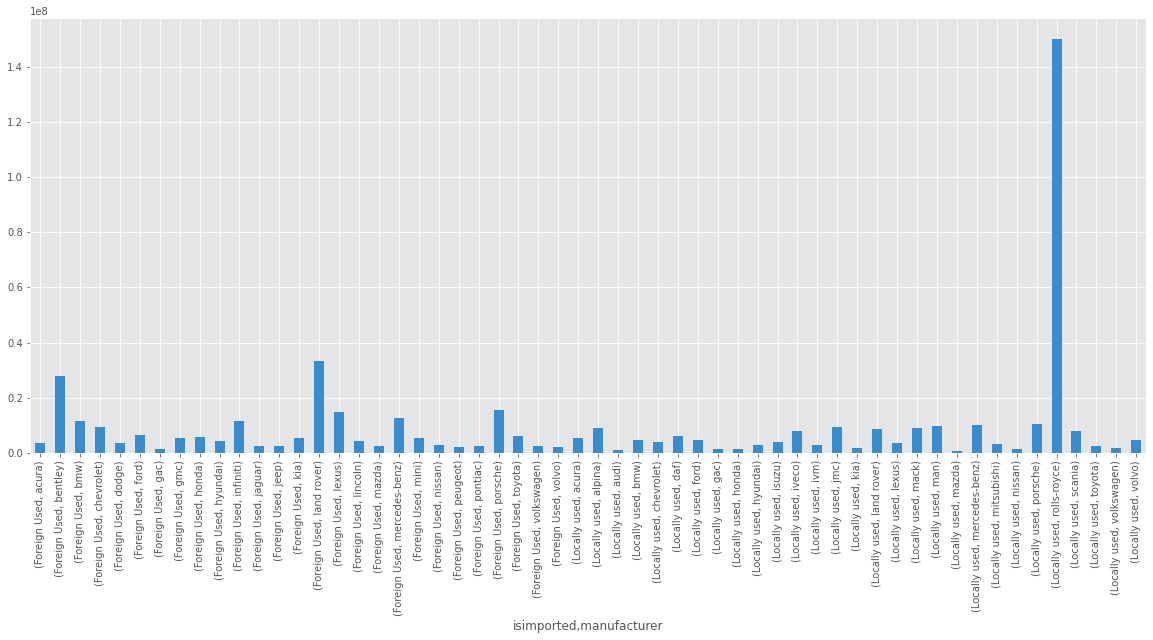

In [64]:
train_df[train_df['isimported'] != 'New'].groupby(['isimported', 'manufacturer'])['target'].mean().plot(kind='bar');

In [65]:
display(train_df['isimported'].value_counts())
display(test_df['isimported'].value_counts())

Foreign Used    744
Locally used    245
New              23
Name: isimported, dtype: int64

Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

In [66]:
print(clr.S + "isimported에 대한 일원분산분석" +clr.E)

A = train_df.loc[train_df['isimported'] == 'Foreign Used', 'target']
B = train_df.loc[train_df['isimported'] == 'Locally used', 'target']
C = train_df.loc[train_df['isimported'] == 'New', 'target']

print(clr.S + "각 그룹의 분포가 정규분포를 따르는지 확인" +clr.E)

print(kstest(A, 'norm'))
print(kstest(B, 'norm'))
print(kstest(C, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(A, B, C))

isimported에 대한 일원분산분석
각 그룹의 분포가 정규분포를 따르는지 확인
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=98.17443842612515, pvalue=1.1007840820725697e-39)


In [67]:
# 사후분석
print(clr.S + "p-value가 0에 수렴하므로 유의한 차이 존재" +clr.E)
Group = ["A"] * len(A) + ["B"] * len(B) + ["C"] * len(C)
Data = A.tolist() + B.tolist() + C.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value가 0에 수렴하므로 유의한 차이 존재


group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-4381401.2659,0.001,-6344840.5098,-2417962.022,True
A,C,30045914.2294,0.001,24402575.3853,35689253.0734,True
B,C,34427315.4953,0.001,28614195.7639,40240435.2267,True


## engine에 따른 가격 차이
H : Horizontal
V : Vertical
I : Incline 
- ~~차종에 따라 달라지는 중요한 특징이라고 생각해서 따로 분리~~ 분리 후 corr 확인 결과 다중공선성 발생.
- 실린더 개수인 맨 앞 한자리 숫자만 남김



In [68]:
train_df['engine'] = train_df['engine'].apply(lambda x: x.strip())

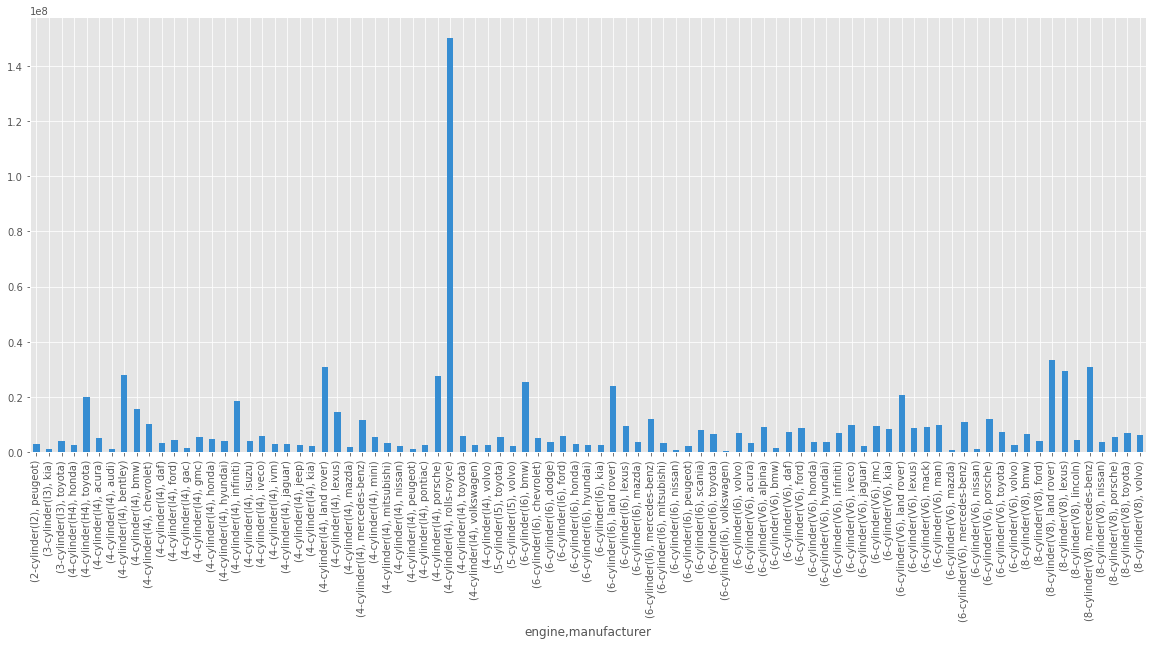

In [69]:
train_df.groupby(['engine', 'manufacturer'])['target'].mean().plot(kind='bar');

In [70]:
train_df['cylinder'] = train_df['engine'].str[0].astype(int)
# train_df['engine'] = train_df['engine'].str[-3:-2]

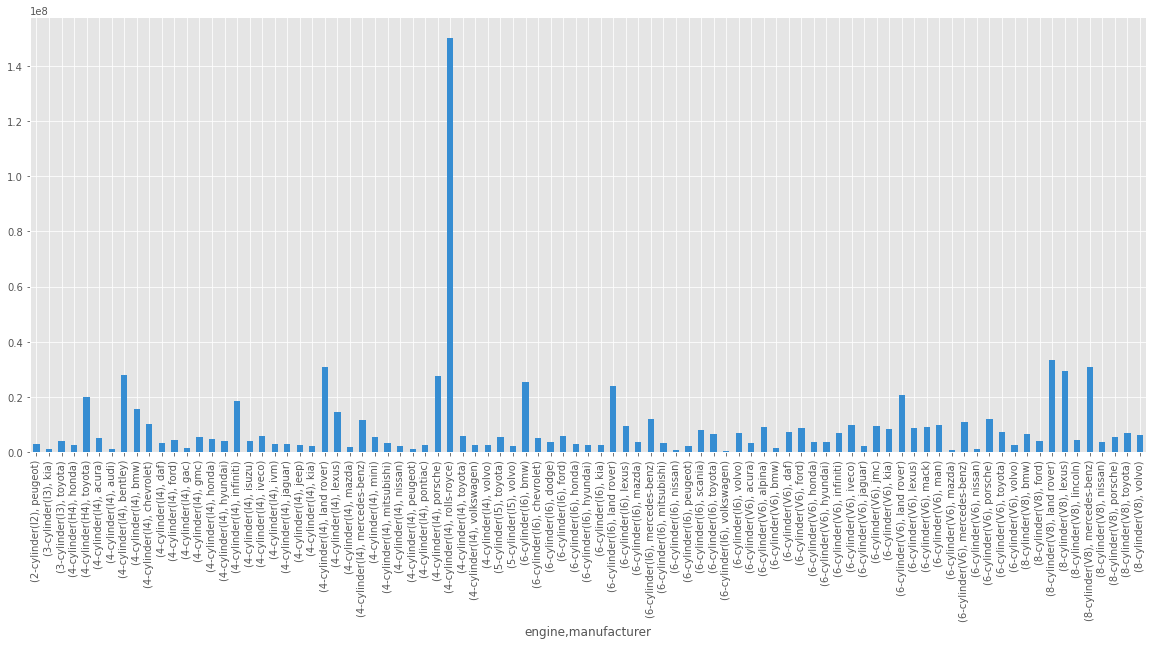

In [71]:
train_df.groupby(['engine', 'manufacturer'])['target'].mean().plot(kind='bar');

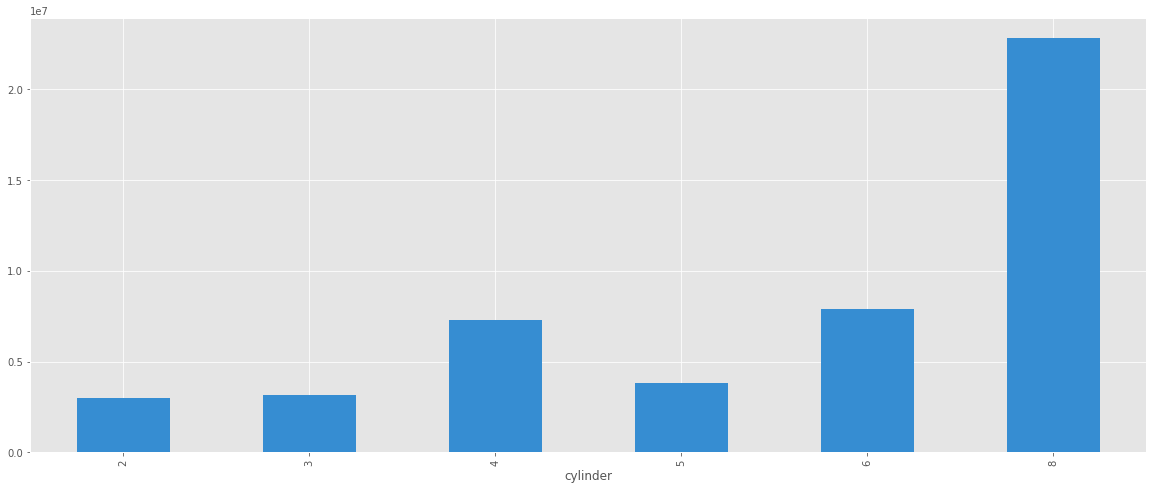

In [72]:
train_df.groupby(['cylinder'])['target'].mean().plot(kind='bar');

In [73]:
pearson_r = pearsonr(train_df['cylinder'], train_df['target'])
print(clr.S + "피어슨 상관계수:" +clr.E + f"{pearson_r[0]}, " + clr.S + " p-value: " + clr.E + f"{pearson_r[1]}")

피어슨 상관계수:0.17976750648439765,  p-value: 8.478344383985332e-09


선형관계가 성립하므로 4를 제외하고 실린더 수가 많을 수록 가격이 높아진다고 할 수 있다. 

In [74]:
test_df[test_df['engine'] == '12-cylinder(V12)']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
142,142,mercedes-benz maybach,6758.0,lagos,New,12-cylinder(V12),automatic,petrol,Black,2019,mercedes-benz,maybach


In [75]:
test_df['engine'] = test_df['engine'].apply(lambda x: x.strip())
test_df['cylinder'] = (test_df['engine'].str[0]).astype(int)
# test_df['engine'] = test_df['engine'].str[-3:-2]

In [76]:
# test_df.loc[test_df['id'] == 142, 'engine'] = 'V'
test_df.loc[test_df['id'] == 142, 'cylinder'] = 12
# test_df['cylinder'] = test_df['cylinder'].astype(int)

In [77]:
display(train_df['engine'].value_counts())
display(test_df['engine'].value_counts())
display(train_df['cylinder'].value_counts())
display(test_df['cylinder'].value_counts())

4-cylinder(I4)    618
6-cylinder(V6)    219
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

4    620
6    337
8     49
3      3
5      2
2      1
Name: cylinder, dtype: int64

4     278
6     133
8      21
5       1
2       1
12      1
3       1
Name: cylinder, dtype: int64

In [78]:
train_df['engine_2~3'] = ((train_df['cylinder'] >= 2) & (train_df['cylinder'] < 4)).astype(int)
train_df['engine_4~6'] = ((train_df['cylinder'] >= 4) & (train_df['cylinder'] < 7)).astype(int)
train_df['engine_8~'] = (train_df['cylinder'] >= 8).astype(int)
train_df.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year,cylinder,engine_2~3,engine_4~6,engine_8~
0,0,toyota rav 4,18277.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,toyota,rav 4,3655.400000,4,0,1,0
1,1,toyota land cruiser,10.0,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,toyota,land cruiser,5.000000,4,0,1,0
2,2,land rover range rover evoque,83091.0,lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,land rover,range rover evoque,9232.333333,6,0,1,0
3,3,lexus es 350,91524.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000,lexus,es 350,6537.428571,4,0,1,0
4,4,toyota venza,94177.0,lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000,toyota,venza,8561.545455,6,0,1,0


In [79]:
test_df['engine_2~3'] = ((test_df['cylinder'] >= 2) & (test_df['cylinder'] < 4)).astype(int)
test_df['engine_4~6'] = ((test_df['cylinder'] >= 4) & (test_df['cylinder'] < 7)).astype(int)
test_df['engine_8~'] = (test_df['cylinder'] >= 8).astype(int)
test_df.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_2~3,engine_4~6,engine_8~
0,0,mercedes-benz c 300,1234.0,abuja,New,4-cylinder(I4),automatic,petrol,White,2017,mercedes-benz,c 300,4,0,1,0
1,1,honda accord,29938.0,abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013,honda,accord,4,0,1,0
2,2,mercedes-benz s 550,87501.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012,mercedes-benz,s 550,4,0,1,0
3,3,toyota sienna,180894.0,lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001,toyota,sienna,6,0,1,0
4,4,toyota hiace,104814.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000,toyota,hiace,4,0,1,0


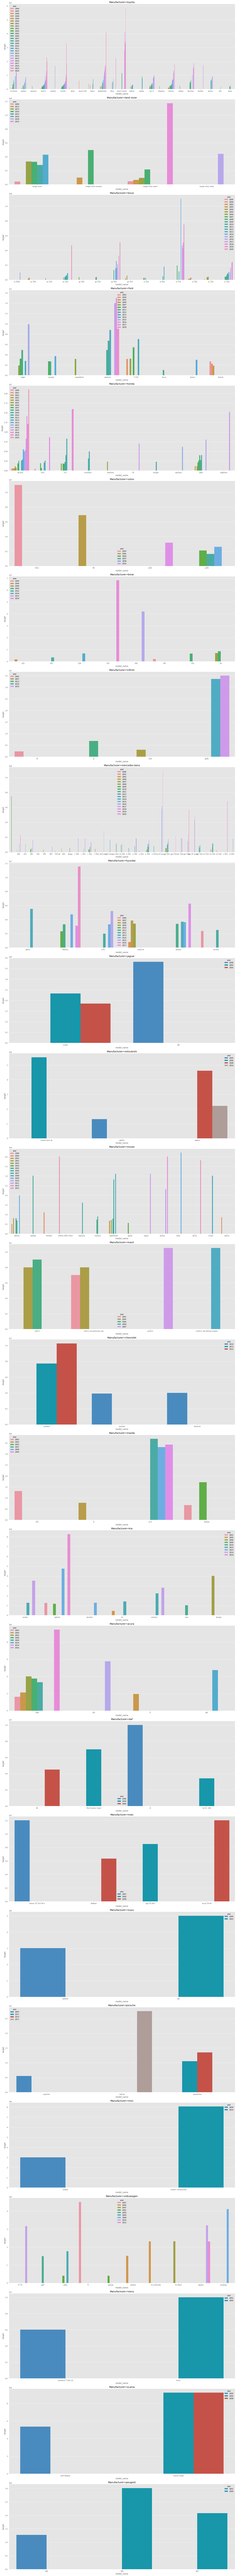

27


In [80]:
n = len(train_df['manufacturer'].unique())
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 8 * n))
count = 0
for manufacturer in train_df['manufacturer'].unique():
    if len(train_df[train_df['manufacturer'] == manufacturer].model_name.unique()) < 2:
        continue
    model_data = train_df[train_df['manufacturer'] == manufacturer].groupby(['model_name', 'year'])['target'].mean().reset_index()
    sns.barplot(data=model_data, x='model_name', y='target', hue='year', ax=ax.flat[count])
    ax.flat[count].set(title='Manufacturer=' + manufacturer)
    count += 1
fig.tight_layout()
for i in range(count, n):
    fig.delaxes(ax.flat[i])
plt.show();
print(count)

## transmission, fuel에 따른 가격
두 그룹이 등분산을 띄므로 feature에서 제외

In [81]:
train_df['transmission'].value_counts()

automatic    965
manual        47
Name: transmission, dtype: int64

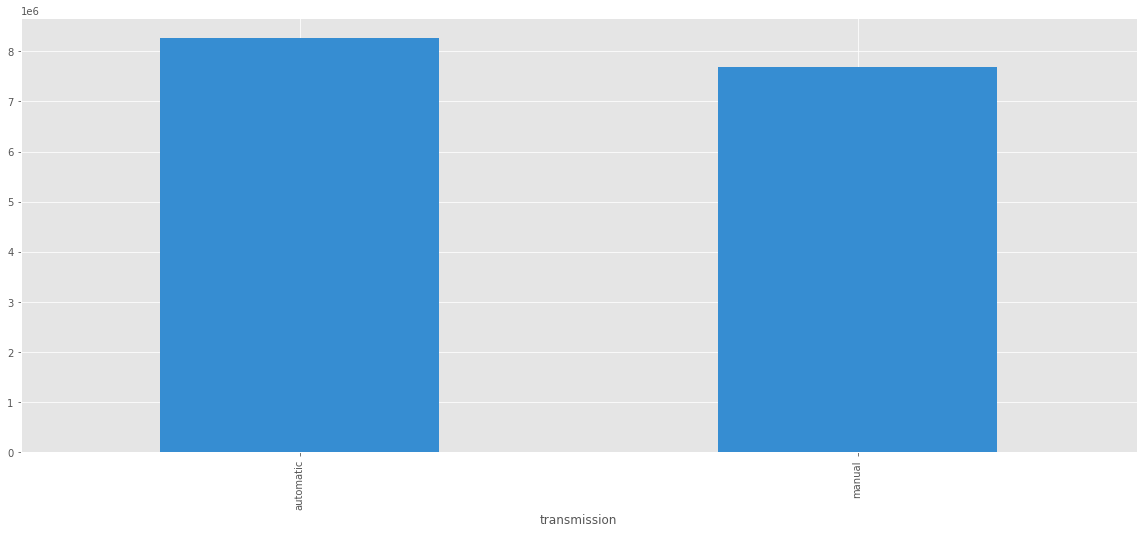

In [82]:
train_df.groupby(['transmission'])['target'].mean().plot(kind='bar');

In [83]:
print(clr.S + "정규성 검정" +clr.E)
print(kstest(train_df.loc[train_df['transmission'] == 'automatic', 'target'], 'norm'))
print(kstest(train_df.loc[train_df['transmission'] == 'manual', 'target'], 'norm'))

print(clr.S + "Levene Test" +clr.E)
print(levene(train_df.loc[train_df['transmission'] == 'automatic', 'target'], train_df.loc[train_df['transmission'] == 'manual', 'target']))

정규성 검정
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
Levene Test
LeveneResult(statistic=0.7190425084246715, pvalue=0.3966590679113585)


In [84]:
train_df['fuel'].value_counts()

petrol    969
diesel     43
Name: fuel, dtype: int64

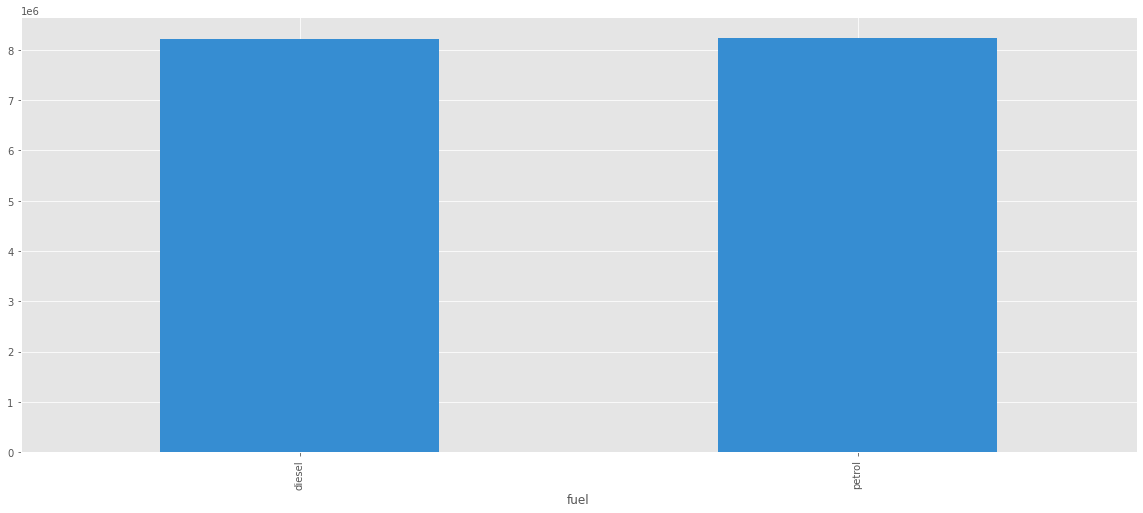

In [85]:
train_df.groupby(['fuel'])['target'].mean().plot(kind='bar');

In [86]:
print(clr.S + "정규성 검정" +clr.E)
print(kstest(train_df.loc[train_df['fuel'] == 'petrol', 'target'], 'norm'))
print(kstest(train_df.loc[train_df['fuel'] == 'diesel', 'target'], 'norm'))

print(clr.S + "Levene Test" +clr.E)
print(levene(train_df.loc[train_df['fuel'] == 'petrol', 'target'], train_df.loc[train_df['fuel'] == 'diesel', 'target']))

정규성 검정
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
Levene Test
LeveneResult(statistic=0.6324379198129362, pvalue=0.4266493218660201)


## 색상에 따른 가격 차이
색상 접두사 제거, 오타 교정 후 주요 색상이 포함되어있는 색상을 체크<br>

In [87]:
train_df['paint'] = train_df['paint'].str.strip()
train_df['paint'] = train_df['paint'].str.lower()
train_df['paint'] = train_df['paint'].str.strip('.')
train_df['paint'].value_counts()

black                     310
white                     143
silver                    109
grey                       87
blue                       78
red                        57
dark grey                  48
gold                       41
green                      20
gray                       18
dark blue                  17
brown                      16
wine                        9
sliver                      5
dark ash                    4
cream                       4
ash                         3
yellow                      3
purple                      3
sky blue                    2
maroon                      2
milk                        2
dark gray                   2
deep blue                   2
white-blue                  2
light silver                1
black sand pearl            1
off white                   1
redl                        1
super white                 1
navy blue                   1
whine                       1
ash and black               1
magnetic g

In [88]:
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('sliver', 'silver'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('ash', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('gery', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('white l', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('milk', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('beige', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('redl', 'red'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('yellow', 'gold'))

In [89]:
train_df['paint'].value_counts()

black                     310
white                     146
silver                    114
gray                      109
blue                       78
red                        58
dark gray                  54
gold                       44
green                      20
dark blue                  17
brown                      16
wine                        9
cream                       4
purple                      3
maroon                      2
white-blue                  2
off white                   2
deep blue                   2
sky blue                    2
whine                       1
magnetic gray metallic      1
gray and black              1
super white                 1
navy blue                   1
black sand pearl            1
light silver                1
black and silver            1
light blue                  1
pale brown                  1
ink blue                    1
silver/gray                 1
dark silver                 1
magnetic gray               1
black/red 

In [90]:
import re
colors = {i:c for i, c in zip(range(6), ['white', 'black', 'gray', 'silver', 'blue', 'red'])}
def what_color(x, color):
    c = colors[color]
    reg = re.findall(x, f'[{c}].')
    if ''.join(reg) == c:
        return True
    else:
        return False

In [91]:
train_df['paint'].apply(lambda x: what_color(x, 0)).value_counts()

False    866
True     146
Name: paint, dtype: int64

In [92]:
test_df['paint'] = test_df['paint'].str.strip()
test_df['paint'] = test_df['paint'].str.lower()
test_df['paint'] = test_df['paint'].str.strip('.')
test_df['paint'].value_counts()

black                      124
silver                      63
white                       61
red                         36
grey                        32
blue                        31
dark grey                   14
gray                        13
green                       12
gold                        11
brown                        6
dark blue                    5
yellow                       3
dark green                   3
sliver                       3
cream                        2
light grey                   2
wine                         2
ash                          2
navy blue                    1
beige                        1
classic silver met(1f7)      1
grey and black               1
indigo ink pearl             1
white and green              1
golf                         1
dark ash                     1
blac                         1
maroon                       1
mint green                   1
Name: paint, dtype: int64

In [93]:
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('ash', 'gray'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('yellow', 'gold'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('golf', 'gold'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('blac', 'black'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('sliver', 'silver'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('beige', 'brown'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('cream', 'white'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('blackk', 'black'))

In [94]:
test_df['paint'].value_counts()

black                      125
silver                      66
white                       63
gray                        47
red                         36
blue                        31
dark gray                   15
gold                        15
green                       12
brown                        7
dark blue                    5
dark green                   3
light gray                   2
wine                         2
maroon                       1
white and green              1
navy blue                    1
indigo ink pearl             1
gray and black               1
classic silver met(1f7)      1
mint green                   1
Name: paint, dtype: int64

## numerical data
### odometer 주행거리에 따른 가격
왜도와 첨도가 높음. 로그변환 수행필요<br>
중고차인데 주행거리가 0? <br>
주행거리와 가장 관련이 있는 year에 이상치가 동시에 존재하는 경우도 있음 ex. 2626.. (위에서 처리함)<br> 
이걸 어떻게 처리하느냐에 따라 점수가 달라질 것으로 보임

왜도 3.0684237113848956
첨도 15.873500627723956


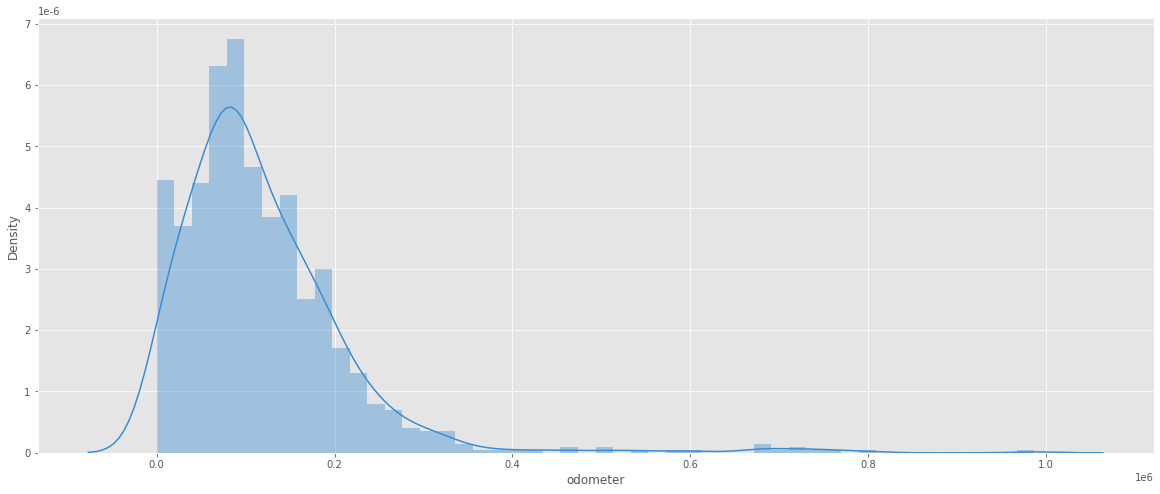

In [95]:
print(clr.S + "왜도"+clr.E, skew(train_df['odometer']))
print(clr.S + "첨도"+clr.E, kurtosis(train_df['odometer']))
sns.distplot(train_df['odometer'], kde=True);

왜도 5.651093536294774
첨도 53.07371642219601


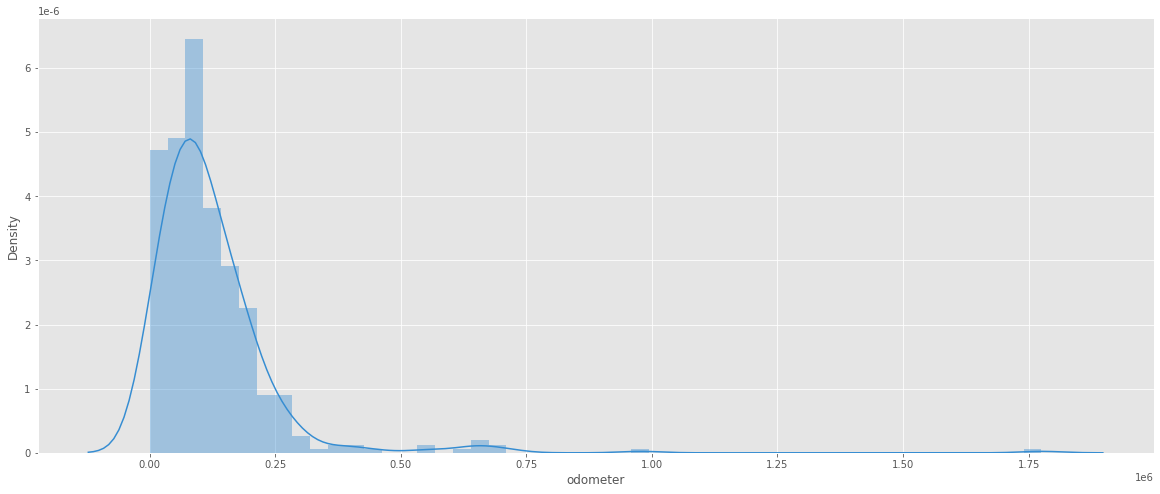

In [96]:
print(clr.S + "왜도"+clr.E, skew(test_df['odometer']))
print(clr.S + "첨도"+clr.E, kurtosis(test_df['odometer']))
sns.distplot(test_df['odometer'], kde=True);

## target 데이터 분포 확인

왜도 4.957476807896737
첨도 35.4543777047707


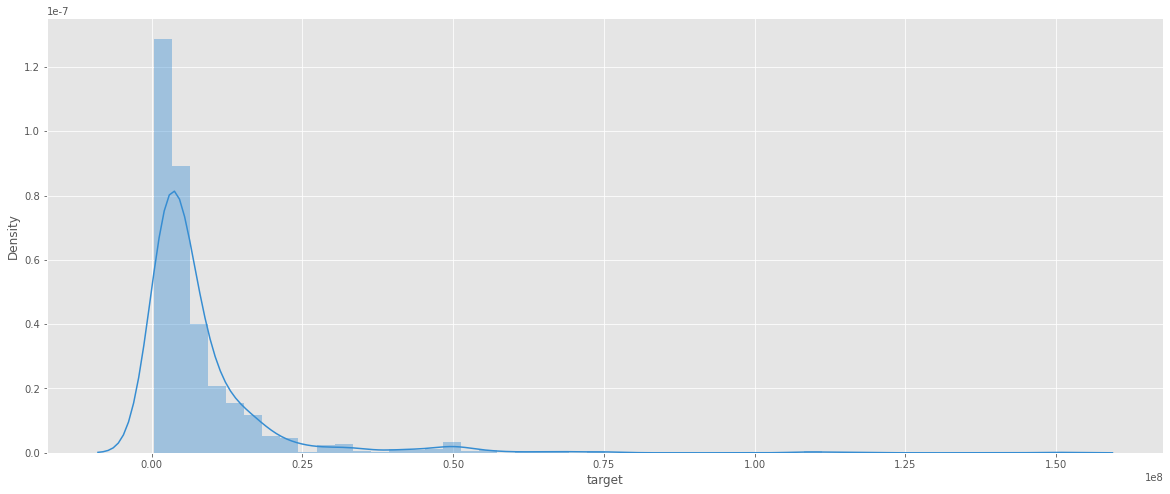

In [97]:
print(clr.S + "왜도"+clr.E, skew(train_df['target']))
print(clr.S + "첨도"+clr.E, kurtosis(train_df['target']))
sns.distplot(train_df['target'], kde=True);

## 이상치 처리<br>
데이터가 작아서 삭제하기엔 조금 부담



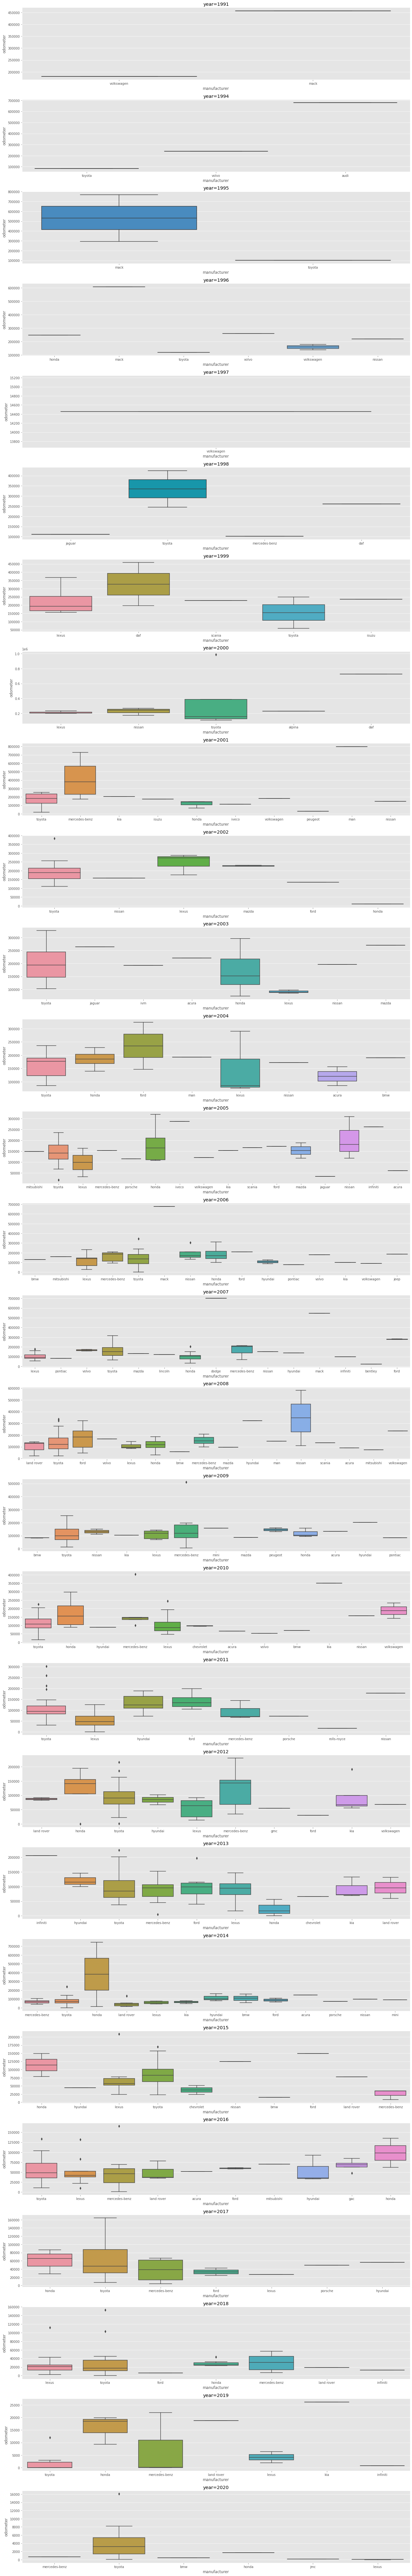

In [98]:
n = len(train_df['year'].unique())
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(18, 4 * n))
for i, year in enumerate(sorted(train_df['year'].unique())):
    sns.boxplot(data=train_df[train_df['year'] == year], x='manufacturer', y='odometer', ax=ax.flat[i]);
    ax.flat[i].set(title='year=' + str(year))
fig.tight_layout()
plt.show();

In [99]:
train_df[(train_df['manufacturer'] == 'toyota')& (train_df['year'] < 2001)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,odometer_per_year,cylinder,engine_2~3,engine_4~6,engine_8~
128,128,toyota sienna,186573.0,lagos,Locally used,6-cylinder(I6),automatic,petrol,gold,2000,965000,toyota,sienna,8884.428571,6,0,1,0
190,190,toyota sienna,987322.0,lagos,Locally used,6-cylinder(V6),automatic,petrol,gold,2000,765000,toyota,sienna,47015.333333,6,0,1,0
200,200,toyota sienna,424963.0,lagos,Locally used,6-cylinder(I6),automatic,petrol,gray,1998,1170000,toyota,sienna,18476.652174,6,0,1,0
226,226,toyota hiace,84789.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,dark gray,1994,3975000,toyota,hiace,3140.333333,4,0,1,0
350,350,toyota dyna,119294.0,lagos,Locally used,4-cylinder(I4),automatic,petrol,white,1996,1015000,toyota,dyna,4771.760000,4,0,1,0
523,523,toyota hiace,109512.0,lagos,Foreign Used,4-cylinder(I4),manual,petrol,green,2000,2765000,toyota,hiace,5214.857143,4,0,1,0
661,661,toyota camry,245417.0,lagos,Locally used,4-cylinder(I4),automatic,petrol,black,1998,565000,toyota,camry,10670.304348,4,0,1,0
719,719,toyota dyna 200,101357.0,lagos,Locally used,4-cylinder(I4),manual,diesel,white-blue,1995,6015000,toyota,dyna 200,3898.346154,4,0,1,0
728,728,toyota sienna,59535.0,lagos,Locally used,6-cylinder(V6),automatic,petrol,gray,1999,1060000,toyota,sienna,2706.136364,6,0,1,0
775,775,toyota avalon,131349.0,lagos,Locally used,6-cylinder(V6),automatic,petrol,silver,2000,715000,toyota,avalon,6254.714286,6,0,1,0


### title 변수 파생 
- 전체 모델명으로 그루핑하는것은 훈련데이터에 없는 모델이 너무 많아서 부적절해보임<br>



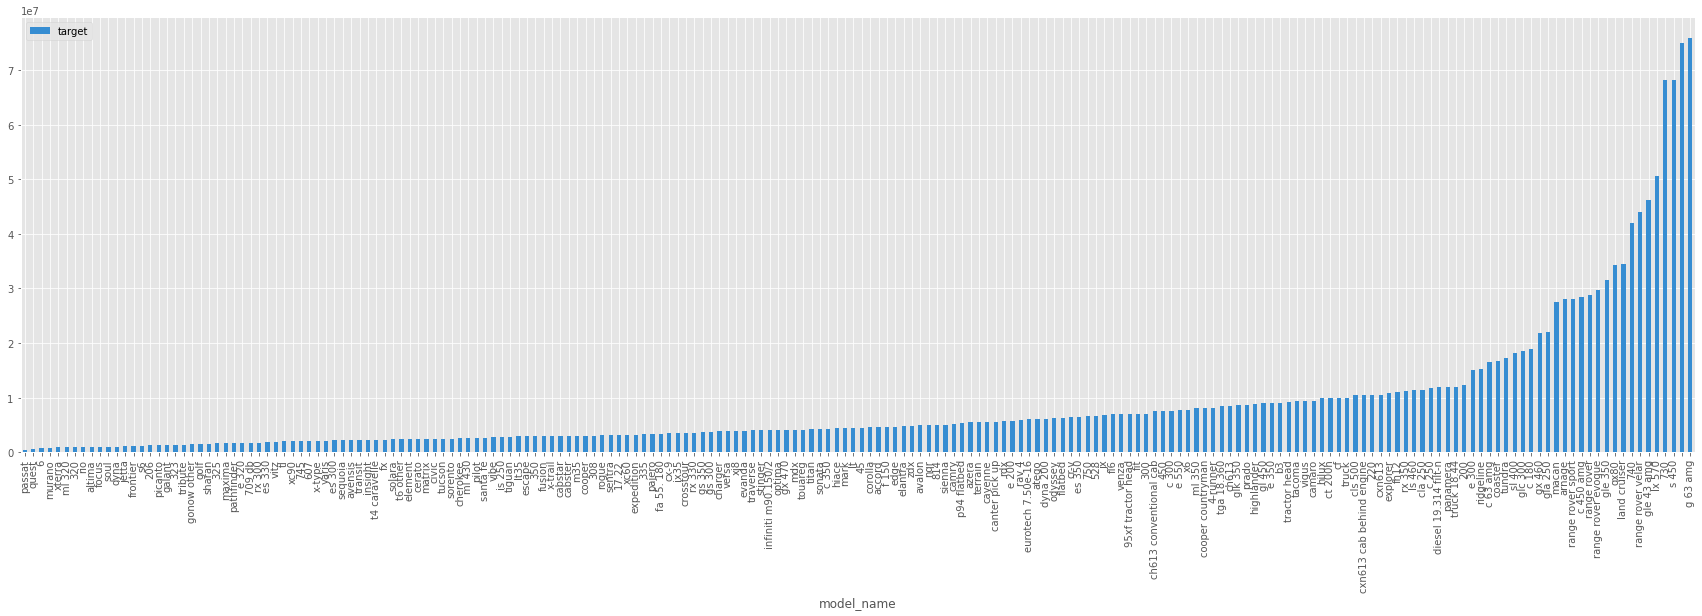

In [100]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('model_name')['target'].mean().reset_index().sort_values(by='target').set_index('model_name').plot(kind='bar', figsize=(30, 8));

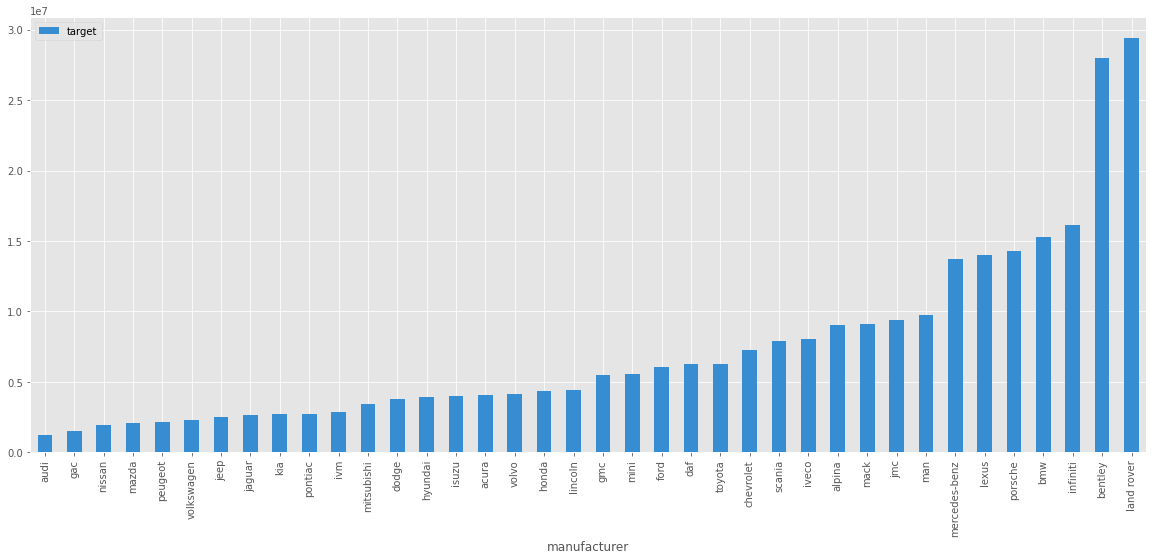

In [101]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

In [102]:
train_df.groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target')['manufacturer'].values

array(['audi', 'gac', 'nissan', 'mazda', 'peugeot', 'volkswagen', 'jeep',
       'jaguar', 'kia', 'pontiac', 'ivm', 'mitsubishi', 'dodge',
       'hyundai', 'isuzu', 'acura', 'volvo', 'honda', 'lincoln', 'gmc',
       'mini', 'ford', 'daf', 'toyota', 'chevrolet', 'scania', 'iveco',
       'alpina', 'mack', 'jmc', 'man', 'mercedes-benz', 'lexus',
       'porsche', 'bmw', 'infiniti', 'bentley', 'land rover',
       'rolls-royce'], dtype=object)

In [174]:
def cluster_manufacturer(x):
    if x in ['audi', 'gac', 'nissan', 'mazda', 'peugeot', 'volkswagen', 'jeep',
       'jaguar', 'kia', 'pontiac', 'ivm']:
       return 1
    elif x in ['mitsubishi', 'dodge', 'hyundai', 'isuzu', 'acura', 'volvo', 'honda', 'lincoln']:
       return 2
    elif x in ['gmc', 'mini', 'ford', 'daf', 'toyota']:
        return 3
    elif x in ['chevrolet', 'scania', 'iveco']:
        return 4
    elif x in ['alpina', 'mack', 'jmc', 'man']:
        return 5
    elif x in ['mercedes-benz', 'lexus', 'porsche', 'bmw', 'infiniti']:
        return 6
    elif x in ['bentley', 'land rover']:
        return 7
    elif x == 'rolls-royce':
        return 8
    else:
        return 0

In [175]:
train_df['cluster'] = train_df['manufacturer'].apply(lambda x: cluster_manufacturer(x))
train_df['cluster'].value_counts()

3    517
6    247
2    129
1     75
7     20
5     13
4     10
8      1
Name: cluster, dtype: int64

In [176]:
test_df['cluster'] = test_df['manufacturer'].apply(lambda x: cluster_manufacturer(x))
test_df['cluster'].value_counts()

3    238
6    102
2     58
1     21
7      6
5      5
4      4
0      1
8      1
Name: cluster, dtype: int64

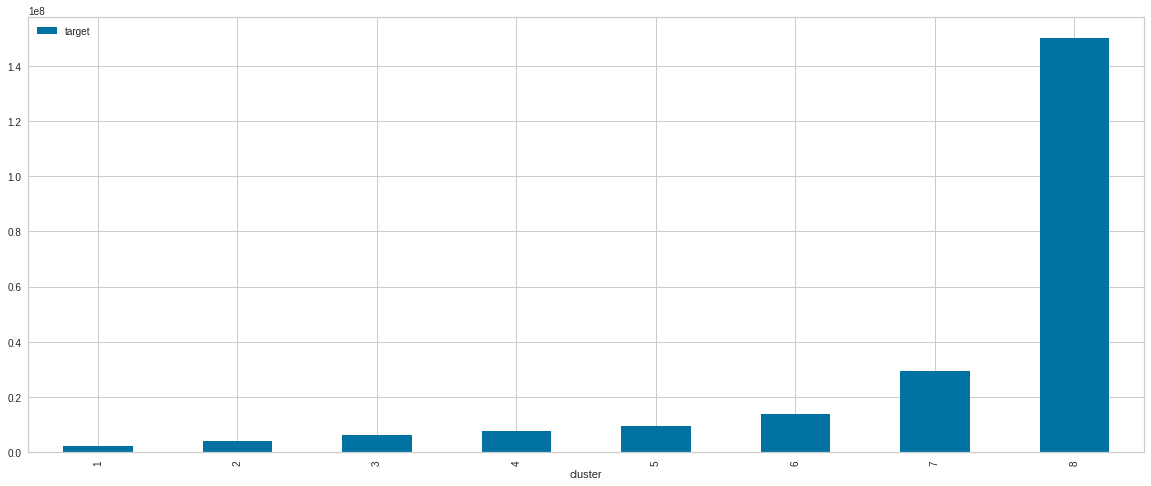

In [160]:
train_df.groupby('cluster')['target'].mean().reset_index().sort_values(by='target').set_index('cluster').plot(kind='bar');

In [107]:
print(train_df.isna().sum())
print(test_df.isna().sum())

id                   0
title                0
odometer             0
location             0
isimported           0
engine               0
transmission         0
fuel                 0
paint                0
year                 0
target               0
manufacturer         0
model_name           0
odometer_per_year    0
cylinder             0
engine_2~3           0
engine_4~6           0
engine_8~            0
cluster              0
dtype: int64
id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
manufacturer    0
model_name      0
cylinder        0
engine_2~3      0
engine_4~6      0
engine_8~       0
cluster         0
dtype: int64


In [108]:
train_df = train_df.reset_index(drop=True)

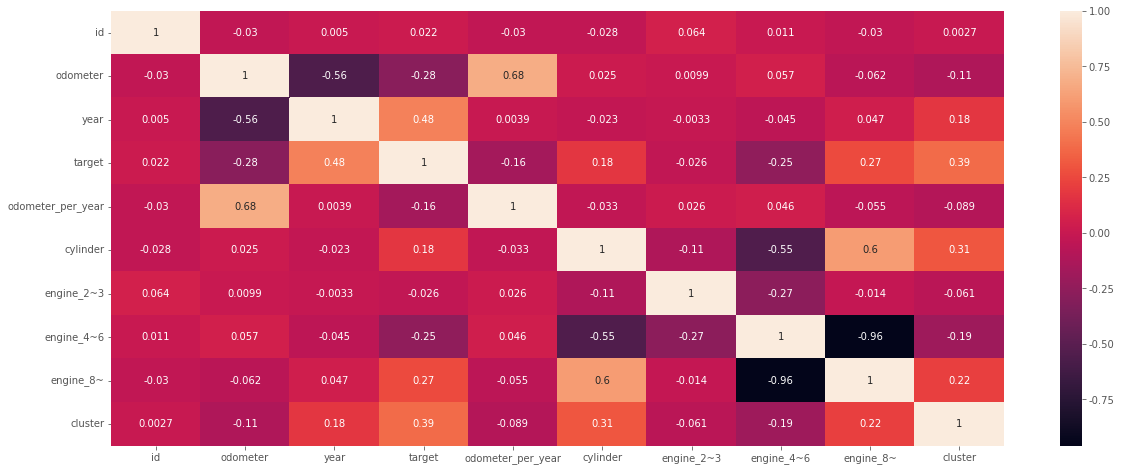

In [109]:
sns.heatmap(train_df.corr(), annot=True);

## 최종 feature

### categorical
- manufacturer : title에서 제조사 분리 <br>
- location : 판매처, [Ogun, other] <br>
- isimported : [Local, New] 원핫인코딩 <br>
- engine : 엔진 종류, [2 ~ 3, 4 ~ 7] 원핫인코딩 <br>
- ~~transmission : 트랜스미션 종류.~~ <br>
- ~~fuel : 연료 종류~~ <br>
- paint : 페인트 색상 (6가지 주요색상으로 원핫인코딩)<br>

### numerical
- odometer : 주행 거리, 0(결측치) 처리, 로그변환 <br>
- cylinder : engine에서 실린더 수만 분리, 4미만, 4~7, 8이상으로 나눔
- year : 제조년도, 이상치 처리, <br> 
- target : 로그변환


In [110]:
# !pip install pycaret
# !pip install catboost
# !pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
# !pip install folium==0.2.1

In [111]:
print(train_df.columns)
print(test_df.columns)

Index(['id', 'title', 'odometer', 'location', 'isimported', 'engine',
       'transmission', 'fuel', 'paint', 'year', 'target', 'manufacturer',
       'model_name', 'odometer_per_year', 'cylinder', 'engine_2~3',
       'engine_4~6', 'engine_8~', 'cluster'],
      dtype='object')
Index(['id', 'title', 'odometer', 'location', 'isimported', 'engine',
       'transmission', 'fuel', 'paint', 'year', 'manufacturer', 'model_name',
       'cylinder', 'engine_2~3', 'engine_4~6', 'engine_8~', 'cluster'],
      dtype='object')


In [182]:
train_X = train_df[['odometer',  'year', 'cylinder', 'engine_2~3', 'engine_4~6']]
test_X = test_df[['odometer',  'year', 'cylinder', 'engine_2~3', 'engine_4~6']]

train_X['year'] = 2021 - train_X['year']
test_X['year'] = 2021 - test_X['year']

# 로그변환
train_X['odometer'] = np.log1p(train_X['odometer'])
test_X['odometer'] = np.log1p(test_X['odometer'])

In [183]:
train_X['location_ogun'] = (train_df['location'] == 'ogun').astype(int)
test_X['location_ogun'] = (test_df['location'] == 'ogun').astype(int)
train_X['location_other'] = ((train_df['location'] != 'ogun') & (train_df['location'] != 'lagos') & (train_df['location'] != 'abuja')).astype(int)
test_X['location_other'] = ((test_df['location'] != 'ogun') & (test_df['location'] != 'lagos') & (test_df['location'] != 'abuja')).astype(int)

train_X['isimported_New'] = (train_df['isimported'] == 'New').astype(int)
test_X['isimported_New'] = (test_df['isimported'] == 'New').astype(int)
train_X['isimported_Local'] = (train_df['isimported'] == 'Locally used').astype(int)
test_X['isimported_Local'] = (test_df['isimported'] == 'Locally used').astype(int)

In [184]:
for i in range(1, 9):
    train_X['manufacturer_' + str(i)] = (train_df['cluster'] == i).astype(int)
    test_X['manufacturer_' + str(i)] = (test_df['cluster'] == i).astype(int)

In [185]:
print(train_X.columns)
print(test_X.columns)

Index(['odometer', 'year', 'cylinder', 'engine_2~3', 'engine_4~6',
       'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8'],
      dtype='object')
Index(['odometer', 'year', 'cylinder', 'engine_2~3', 'engine_4~6',
       'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8'],
      dtype='object')


In [115]:
# def ohe_fit_transform(train_df, test_df, col_names:list, drop_last:bool):
#     one_hot_cols = {col_name:train_df[col_name].unique().tolist() for col_name in col_names}
#     if drop_last:
#         for key in one_hot_cols.keys():
#             one_hot_cols[key].pop()
#     for col_name, values in one_hot_cols.items():            
#         for value in values:
#             train_df[col_name + '_' + value] = (train_df[col_name] == value).astype(int)
#             test_df[col_name + '_' + value] = (test_df[col_name] == value).astype(int)
#     train_df.drop(col_names, axis=1, inplace=True)
#     test_df.drop(col_names, axis=1, inplace=True)
#     return train_df, test_df

In [116]:
# train_X, test_X = ohe_fit_transform(train_X, test_X, ["location", "isimported", 'engine'], True)

In [186]:
# # 더미화 feature engine
# dummy_model = OHE(variables = ["location", "isimported", 'engine', "manufacturer"], drop_last=True)#  top_categories=8
# train_X = dummy_model.fit_transform(train_X)
# test_X = dummy_model.transform(test_X)

# 색상 원핫인코딩
for i, color in enumerate(['white', 'black', 'gray', 'silver', 'blue', 'red']):
    train_X['color_'+color] = train_df['paint'].apply(lambda x: what_color(x, i)).astype(int)

for i, color in enumerate(['white', 'black', 'gray', 'silver', 'blue', 'red']):
    test_X['color_'+color] = test_df['paint'].apply(lambda x: what_color(x, i)).astype(int)

In [187]:
train_X['target'] = np.log1p(train_df['target'])
# train_y = train_X.pop('target')

In [188]:
print(train_X.columns)
print(test_X.columns)

Index(['odometer', 'year', 'cylinder', 'engine_2~3', 'engine_4~6',
       'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_white', 'color_black', 'color_gray', 'color_silver',
       'color_blue', 'color_red', 'target'],
      dtype='object')
Index(['odometer', 'year', 'cylinder', 'engine_2~3', 'engine_4~6',
       'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_white', 'color_black', 'color_gray', 'color_silver',
       'color_blue', 'color_red'],
      dtype='object')


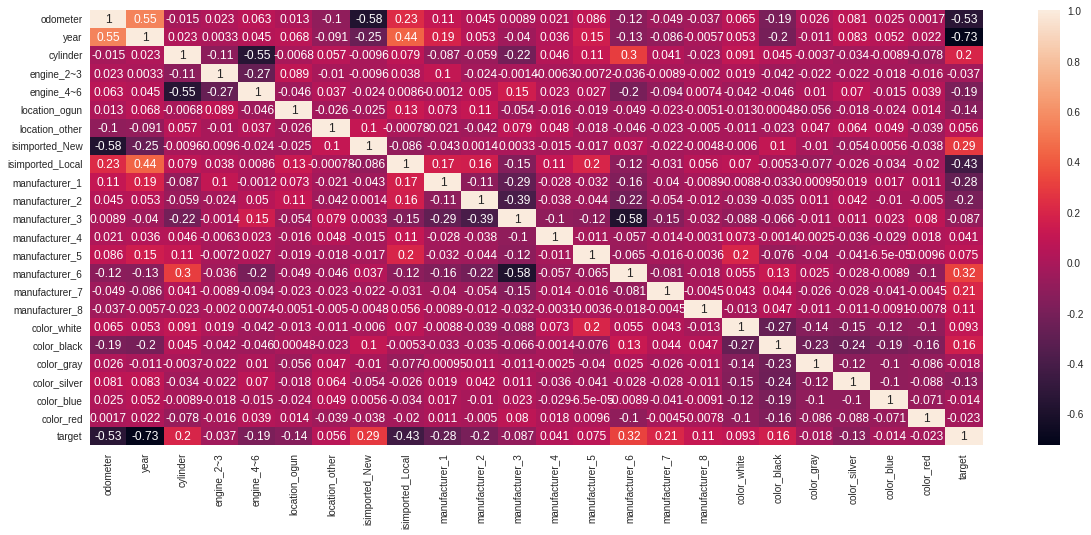

In [189]:
sns.heatmap(train_X.corr(), annot=True);

# search model

In [120]:
from pycaret.regression import *

In [191]:
ignore_features = []
cat_features = ['engine_2~3', 'engine_4~6',
       'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_white', 'color_black', 'color_gray', 'color_silver',
       'color_blue', 'color_red']
num_features = ['odometer', 'cylinder', 'year']

In [192]:
reg = setup(data=train_X,
            categorical_features=cat_features,
            numeric_features=num_features,
            ignore_features=ignore_features,
            target="target",
            train_size=.8,
            session_id=1,
            # profile=True
            )

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(1012, 24)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,20
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(809, 23)"


In [193]:
best_models = compare_models(sort='mae', n_select=3, fold=5, verbose=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.3100,0.1988,0.4439,0.7890,0.0269,0.0201,1.866
gbr,Gradient Boosting Regressor,0.3130,0.2073,0.4544,0.7796,0.0275,0.0202,0.090
rf,Random Forest Regressor,0.3164,0.2192,0.4666,0.7672,0.0282,0.0205,0.596
et,Extra Trees Regressor,0.3381,0.2492,0.4983,0.7345,0.0302,0.0219,0.546
lightgbm,Light Gradient Boosting Machine,0.3404,0.2279,0.4763,0.7572,0.0287,0.0220,0.110
lr,Linear Regression,0.3514,0.2505,0.4987,0.7331,0.0302,0.0227,0.562
ridge,Ridge Regression,0.3520,0.2503,0.4986,0.7335,0.0302,0.0227,0.016
lar,Least Angle Regression,0.3520,0.2545,0.5023,0.7294,0.0304,0.0227,0.022
br,Bayesian Ridge,0.3522,0.2509,0.4992,0.7327,0.0303,0.0228,0.016
knn,K Neighbors Regressor,0.3621,0.2732,0.5204,0.7105,0.0314,0.0234,0.074


In [194]:
tuned_top3 = [tune_model(model, fold=5, optimize='mae') for model in best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3756,0.2531,0.5031,0.7236,0.0308,0.0246
1,0.3509,0.2586,0.5085,0.7046,0.0306,0.0226
2,0.3971,0.2702,0.5198,0.7087,0.0315,0.0257
3,0.3816,0.3139,0.5603,0.7125,0.0331,0.0243
4,0.3572,0.2121,0.4606,0.7608,0.0286,0.0235
Mean,0.3725,0.2616,0.5105,0.7220,0.0309,0.0242
Std,0.0167,0.0327,0.0320,0.0204,0.0015,0.0010


In [195]:
blended_models = blend_models(estimator_list=tuned_top3, fold=5, optimize='mae')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3093,0.1812,0.4257,0.8021,0.0262,0.0203
1,0.3120,0.2133,0.4619,0.7563,0.0279,0.0202
2,0.3310,0.2047,0.4524,0.7794,0.0273,0.0213
3,0.3216,0.2484,0.4984,0.7725,0.0293,0.0204
4,0.2992,0.1585,0.3981,0.8212,0.0248,0.0197
Mean,0.3146,0.2012,0.4473,0.7863,0.0271,0.0204
Std,0.0109,0.0304,0.0339,0.0228,0.0015,0.0005


In [196]:
finalized_model = finalize_model(blended_models)
y_pred = predict_model(finalized_model, data=test_X)

In [197]:
y_pred = np.expm1(y_pred["Label"].values)

In [198]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = y_pred
sample_submission.head()

,id,target
0,0,2.084987e+07
1,1,5.739595e+06
2,2,6.062778e+06
3,3,1.476913e+06
4,4,2.589582e+06


In [199]:
sample_submission.to_csv('submission.csv', index=False)